In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Please unzip the archive using suitable path to the fruit dataset archive
!unzip "/content/drive/MyDrive/fruit dataset/archive.zip"

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/111_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Traini



##Importing Libraries

In [ ]:
from sklearn.model_selection import train_test_split
from skimage import feature
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.metrics import classification_report, accuracy_score

##Function to extract the Color Histogram :

This histogram represents the color distribution of the image. We will use this as the first part of our feature vector.

In [ ]:
def color_hist(img, bins = (10, 10, 10)):

  # Resizing the input image
  img = cv2.resize(img, (100, 100))
  
  # Calculating the histogram
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  hist = cv2.calcHist([hsv], [0,1,2], None, bins, [0, 180, 0, 256, 0, 256])
  
  # Normalising the Histogram
  cv2.normalize(hist, hist)
  
  # Flattening the histogram before returning
  return hist.flatten()

# Function to calculate HOG of the image

This represents the edges in our image. We will use this as the second part of our feature vector.

In [ ]:
def HOG_Calculate(image):

  # Resizing the input image
  image = cv2.resize(image, (100, 100))

  # Feature has been imported from the skimage library
  (hog, hog_image) = feature.hog(image, orientations=9, 
                      pixels_per_cell=(10, 10), cells_per_block=(2, 2), 
                      block_norm='L2-Hys', visualize=True, transform_sqrt=True, multichannel=True)

  # Flattening the HOG before returning
  return hog_image.flatten()

In [ ]:
def show_Hog_Image(image):
  # Resizing the input image
  image = cv2.resize(image, (100, 100))

  # Feature has been imported from the skimage library
  (hog, hog_image) = feature.hog(image, orientations=9, 
                      pixels_per_cell=(10, 10), cells_per_block=(2, 2), 
                      block_norm='L2-Hys', visualize=True, transform_sqrt=True, multichannel=True)

  plt.imshow((hog_image*255)[...,::-1])

# Creating the Classifier Class on which we will base our ML Models

In [ ]:
# Implement Learning by Prototypes Classifier where class prototype is the mean of the training examples of that class 
# To classify a test image, find the prototype with the shortest distance.
from collections import OrderedDict

class LearningWithPrototypes:

    # Constructor Function for our class
    def __init__(self):
        self.class_prototype = OrderedDict()  # class prototypes
        self.class_count = OrderedDict()  # label frequency array
        self.class_name = []  # labels

    # Training Function for our class
    def fit(self, X, y):

        # Loop over all the input feature vectors
        for i in range(len(y)):

            if y[i] not in self.class_name:
                # Encountering a new label for the first time
                self.class_name.append(y[i])
                self.class_prototype[y[i]] = np.zeros(len(X[0]))
                self.class_count[y[i]] = 0
            
            # Steps for the mean calculation for this class's prototype
            self.class_prototype[y[i]] += X[i]
            self.class_count[y[i]] += 1

        # Looping over the prototype dictionary to calculate mean
        for key in self.class_prototype:
            self.class_prototype[key] = self.class_prototype[key]/self.class_count[key]
    
    # Function to predict labels for multiple feature vectors based on Eucledian Distance
    def predict_E(self, X):
        
        # Predictions array
        pred = []

        # Looping over all feature vectors
        for i in range(len(X)):

            # Distance array
            dist = []
            
            # Calculating the distance of our feature vector from all the prototypes
            for key in self.class_prototype:
                dist.append(np.linalg.norm(X[i] - self.class_prototype[key]))
                # dist.append(spatial.distance.cosine(X[i], self.class_prototype[key]))
                

            # Taking the label of the prototype at the minimum distance
            pred.append(self.class_name[dist.index(min(dist))])
        
        # Returning the predictions array
        return np.array(pred)

    # Function to predict labels for multiple feature vectors based on Cosine Distance
    def predict_C(self, X):
        
        # Predictions array
        pred = []

        # Looping over all feature vectors
        for i in range(len(X)):

            # Distance array
            dist = []
            
            # Calculating the distance of our feature vector from all the prototypes
            for key in self.class_prototype:
                # dist.append(np.linalg.norm(X[i] - self.class_prototype[key]))
                dist.append(spatial.distance.cosine(X[i], self.class_prototype[key]))
                

            # Taking the label of the prototype at the minimum distance
            pred.append(self.class_name[dist.index(min(dist))])
        
        # Returning the predictions array
        return np.array(pred)



#Extracting Images and their Features from the Dataset

In [ ]:
# Root Directory for the Training Images Folder
rootdir = './fruits-360_dataset/fruits-360/Training'

# Features array
features = []
# Labels array
imageLables = []

imageCount = 0

# Looping over all the subdirectories, directories, and files in the Root directory
for subdir, dir, files in os.walk(rootdir):
  
  # Looping over the images
  for file in files:
    
    # Reading the image
    img = cv2.imread(os.path.join(subdir, file))

    # Extracting the label from the image name
    imageLables.append(str(subdir).split('/')[-1])

    # Calculating the color histogram of the image
    colorDistribution = color_hist(img, (10, 10, 10))

    # Calculating the HOG for our image
    hogDistribution = HOG_Calculate(img)

    # Concatenating the above 2 form a feature and add that 2 the feature array
    features.append(np.concatenate((colorDistribution, hogDistribution)))

  #   imageCount += 1
  #   if imageCount > 500:
  #     break
  # if imageCount > 500:
  #   break  
    
# Converting the lists into numpy arrays for better performance
features = np.array(features)
imageLables = np.array(imageLables)

#Creating the Models

In [ ]:
# Creating the first model for which we have around 131 labels
model = LearningWithPrototypes()

"""
Label Merging Process (Tried this for better accuracy but failed):

Imagine we have 2 labels:
1. Apple 1
2. Apple 2

We want to consider them both as just 'Apple'.
So we will consider only the first part of any label.

Drawback: Model won't be able to predict which variety of fruit we have in our image
"""
# Creating the second model which will be trained with merged labels
model2 = LearningWithPrototypes()

#Training the Models


In [ ]:
# Training the first model
model.fit(features, imageLables)

# Training the second model on merged labels
model2.fit(features, np.array([i.split()[0] for i in imageLables]))

In [ ]:
import pickle
# SAVING THE MODEL
filename = './MODEL1.sav'
filename2 = './MODEL2.sav'
pickle.dump(model, open(filename, 'wb'))
pickle.dump(model2, open(filename2, 'wb'))

# # load the model from disk
# model = pickle.load(open(filename, 'rb'))
# model2 = pickle.load(open(filename2, 'rb'))

#Checking our models on a test image

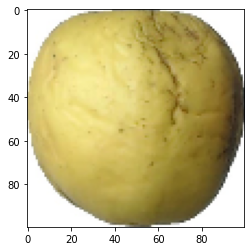

In [ ]:
# Path of the Image
imagePath = "./fruits-360-original-size/fruits-360-original-size/Training/apple_golden_1/r0_0.jpg"

# Reading the Image
testImage = cv2.resize(cv2.imread(imagePath), (100, 100))

plt.imshow(testImage[:,:,::-1])

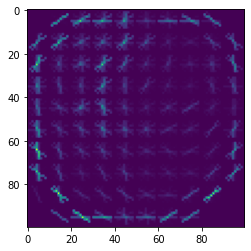

In [ ]:
# We are plotting using matplotlib which is showing distorted colors. 
# But the 2 colors are sufficient to correctly visualize the HOG.
show_Hog_Image(testImage)

In [ ]:
# Calculating the Feature vector for this test image
colorDistribution = np.array(color_hist(testImage, (10, 10, 10)))
hogDistribution = np.array(HOG_Calculate(testImage))

feature_array = np.array([np.concatenate((colorDistribution, hogDistribution))])

# Predicting the Label for the image
prediction_E = model.predict_E(feature_array)
prediction_C = model.predict_C(feature_array)
prediction2_E = model2.predict_E(feature_array)
prediction2_C = model2.predict_C(feature_array)

# Printing the Predictions
print(f"Model which was trained on original labels predicted it to be {prediction_E} based on Eucledian Distances.")
print(f"Model which was trained on original labels predicted it to be {prediction_C} based on Cosine Distances.")
print("Model which was trained on merged labels predicted it to be", prediction2_E, 'based on Eucledian Distances.')
print("Model which was trained on merged labels predicted it to be", prediction2_C, 'based on Cosine Distances.')

Model which was trained on original labels predicted it to be ['Apple Red Yellow 1'] based on Eucledian Distances.
Model which was trained on original labels predicted it to be ['Apple Red Yellow 1'] based on Cosine Distances.
Model which was trained on merged labels predicted it to be ['Peach'] based on Eucledian Distances.
Model which was trained on merged labels predicted it to be ['Orange'] based on Cosine Distances.


#Extensive Testing on Final Test Images to check the desired Metrics

Processing the Test images and extracting the features and the labels

In [ ]:
# Root Directory where the Test Images are stored
rootdir = './fruits-360_dataset/fruits-360/Test'

# Features array
features_TEST = []
# Real Labels array
imageLables_TEST = []
count = 0

for subdir, dir, files in os.walk(rootdir):
  for file in files:
    
    # Reading the image
    img = cv2.imread(os.path.join(subdir, file))

    # Extracting the Label
    imageLables_TEST.append(str(subdir).split('/')[-1])

    # Calculating the Color Distribution and HOG of the image
    colorDistribution = color_hist(img, (10, 10, 10))
    hogDistribution = HOG_Calculate(img)

    # Appending the Feature Vector of our Image into the Features array
    features_TEST.append(np.concatenate((colorDistribution, hogDistribution)))
  #   count += 1
  #   if(count > 10):
  #     break
  # if(count > 10):
  #     break

# Converting the Feature array and the Image Labels array into numpy array for better performance
features_TEST = np.array(features_TEST)
imageLables_TEST = np.array(imageLables_TEST)

Checking Accuracy on all Test Images

In [ ]:
# Predicting the labels using both the models
prediction_E = model.predict_E(features_TEST)
prediction_C = model.predict_C(features_TEST)

prediction2_E = model2.predict_E(features_TEST)
prediction2_C = model2.predict_C(features_TEST)

#Printing the required metrics


In [ ]:
def getMetricsFromReport(report):
  # Classification Report has to be generated via classification_report imported from sklearn.metrics
  # For successful parsing
  r = report.split('\n')[-2].split()
  answer = []
  for i in r:
    try:
      answer.append(float(i.strip()))
    except Exception as e:
      pass
  print(r)
  print(answer)
  (p, rec, f1, sup) = answer
  return (p, rec, f1, sup)

In [ ]:
# Printing the Required Metrics for the First Model
report1_E = classification_report(prediction_E, imageLables_TEST)
print(report1_E)

                     precision    recall  f1-score   support

     Apple Braeburn       0.65      0.72      0.68       148
 Apple Crimson Snow       0.78      0.23      0.36       496
     Apple Golden 1       0.71      0.74      0.73       154
     Apple Golden 2       0.51      0.54      0.52       154
     Apple Golden 3       0.91      0.60      0.72       242
 Apple Granny Smith       0.40      0.64      0.49       103
    Apple Pink Lady       0.51      0.50      0.51       155
        Apple Red 1       0.24      0.25      0.24       163
        Apple Red 2       0.96      0.63      0.76       250
        Apple Red 3       0.83      0.93      0.88       129
Apple Red Delicious       0.60      0.75      0.66       132
 Apple Red Yellow 1       0.63      0.53      0.58       197
 Apple Red Yellow 2       0.08      0.30      0.13        60
            Apricot       0.30      0.57      0.40        87
            Avocado       0.43      0.62      0.51       100
       Avocado ripe    

In [ ]:
# Printing the Required Metrics for the First Model
report1_C = classification_report(prediction_C, imageLables_TEST)
print(report1_C)

                     precision    recall  f1-score   support

     Apple Braeburn       0.52      0.46      0.49       186
 Apple Crimson Snow       0.63      0.15      0.25       611
     Apple Golden 1       0.51      0.73      0.60       111
     Apple Golden 2       0.50      0.86      0.63        95
     Apple Golden 3       0.60      0.61      0.60       160
 Apple Granny Smith       0.40      0.62      0.49       107
    Apple Pink Lady       0.50      0.54      0.52       141
        Apple Red 1       0.13      0.24      0.17        87
        Apple Red 2       0.92      0.58      0.71       260
        Apple Red 3       0.85      0.61      0.71       203
Apple Red Delicious       0.50      0.78      0.61       107
 Apple Red Yellow 1       0.60      0.45      0.51       221
 Apple Red Yellow 2       0.06      0.54      0.11        26
            Apricot       0.29      0.39      0.33       119
            Avocado       0.03      0.17      0.05        23
       Avocado ripe    

In [ ]:
p1_E, rec1_E, f1_1_E, sup1_E = getMetricsFromReport(report1_E)
print(p1_E, rec1_E, f1_1_E, sup1_E)
p1_C, rec1_C, f1_1_C, sup1_C = getMetricsFromReport(report1_C)
print(p1_C, rec1_C, f1_1_C, sup1_C)

['weighted', 'avg', '0.53', '0.47', '0.47', '22688']
[0.53, 0.47, 0.47, 22688.0]
0.53 0.47 0.47 22688.0
['weighted', 'avg', '0.49', '0.42', '0.42', '22688']
[0.49, 0.42, 0.42, 22688.0]
0.49 0.42 0.42 22688.0


In [ ]:
# Printing the Required Metrics for the Second Model
report_E = classification_report(prediction2_E, [i.split()[0] for i in imageLables_TEST])
print(report_E)

              precision    recall  f1-score   support

       Apple       0.26      0.65      0.37       862
     Apricot       0.41      0.33      0.37       207
     Avocado       0.47      0.33      0.38       442
      Banana       0.61      0.80      0.69       369
    Beetroot       0.33      0.30      0.31       163
   Blueberry       0.50      0.08      0.13       995
      Cactus       0.50      0.17      0.26       478
  Cantaloupe       0.88      0.85      0.86       340
   Carambula       0.01      0.02      0.01        42
 Cauliflower       0.90      0.89      0.90       237
      Cherry       0.33      0.43      0.38       894
    Chestnut       0.33      0.93      0.48        54
  Clementine       0.11      0.04      0.06       495
       Cocos       0.66      0.65      0.65       170
        Corn       0.27      0.73      0.39       111
    Cucumber       0.29      0.82      0.43       102
       Dates       0.50      0.29      0.37       285
    Eggplant       0.44    

In [ ]:
# Printing the Required Metrics for the Second Model
report_C = classification_report(prediction2_C, [i.split()[0] for i in imageLables_TEST])
print(report_C)

              precision    recall  f1-score   support

       Apple       0.32      0.68      0.44      1018
     Apricot       0.42      0.16      0.23       432
     Avocado       0.47      0.39      0.42       369
      Banana       0.61      0.80      0.69       369
    Beetroot       0.27      0.31      0.29       130
   Blueberry       0.50      0.08      0.14       910
      Cactus       0.50      0.27      0.35       306
  Cantaloupe       0.90      0.76      0.82       389
   Carambula       0.04      0.09      0.06        80
 Cauliflower       0.90      0.73      0.81       290
      Cherry       0.38      0.47      0.42       944
    Chestnut       0.33      0.89      0.49        57
  Clementine       0.27      0.07      0.11       619
       Cocos       0.52      0.71      0.60       121
        Corn       0.31      0.85      0.45       111
    Cucumber       0.29      0.15      0.20       542
       Dates       0.50      0.29      0.37       286
    Eggplant       0.04    

In [ ]:
p2_E, rec2_E, f1_2_E, sup2_E = getMetricsFromReport(report_E)
print(p2_E, rec2_E, f1_2_E, sup2_E)
p2_C, rec2_C, f1_2_C, sup2_C = getMetricsFromReport(report_C)
print(p2_C, rec2_C, f1_2_C, sup2_C)

['weighted', 'avg', '0.47', '0.36', '0.38', '22688']
[0.47, 0.36, 0.38, 22688.0]
0.47 0.36 0.38 22688.0
['weighted', 'avg', '0.44', '0.34', '0.35', '22688']
[0.44, 0.34, 0.35, 22688.0]
0.44 0.34 0.35 22688.0


In [ ]:
# Printing the overall Accuracies
accuracy1_E = accuracy_score(imageLables_TEST, prediction_E)*100
accuracy1_C = accuracy_score(imageLables_TEST, prediction_C)*100
accuracy2_E = accuracy_score([i.split()[0] for i in imageLables_TEST], prediction2_E)*100
accuracy2_C = accuracy_score([i.split()[0] for i in imageLables_TEST], prediction2_C)*100
print(f"The Overall Accuracy of First Model when using Eucledian Distances is {accuracy1_E}%")
print(f"The Overall Accuracy Second Model when using Eucledian Distances is {accuracy2_E}%")
print(f"The Overall Accuracy of First Model when using Cosine Distances is {accuracy1_C}%")
print(f"The Overall Accuracy Second Model when using Cosine Distances is {accuracy2_C}%")

The Overall Accuracy of First Model when using Eucledian Distances is 46.93229901269393%
The Overall Accuracy Second Model when using Eucledian Distances is 36.48184062059238%
The Overall Accuracy of First Model when using Cosine Distances is 41.76216502115656%
The Overall Accuracy Second Model when using Cosine Distances is 34.405853314527505%


Plotting Comparison Curves Curve (Because it's Fun!)

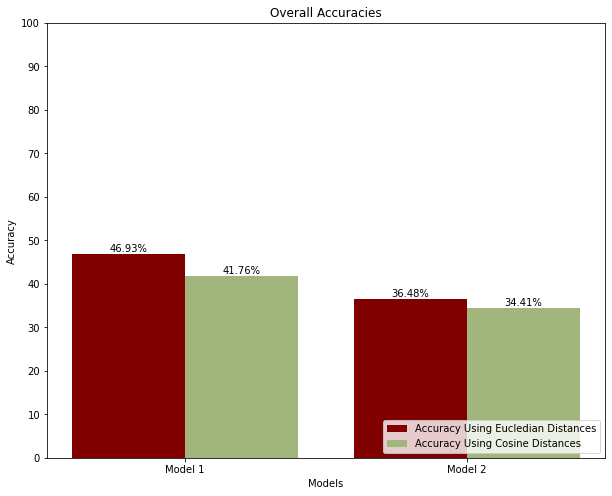

In [ ]:
X = ['Model 1', 'Model 2']
Y_1 = [accuracy1_E, accuracy2_E]
Y_2 = [accuracy1_C, accuracy2_C]
X_Axis = np.arange(len(X))

f = plt.figure()

b1 = plt.bar(X_Axis - 0.2, Y_1, 0.4, color='maroon', label = 'Accuracy Using Eucledian Distances')
b2 = plt.bar(X_Axis + 0.2, Y_2, 0.4, color='#A1B57D', label = 'Accuracy Using Cosine Distances')

for rect in b1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom')

for rect in b2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom')

f.set_figheight(8)
f.set_figwidth(10)
plt.xticks(X_Axis, X)
plt.yticks(np.arange(0, 110, 10))
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Overall Accuracies")
plt.legend(loc=4)
plt.show()

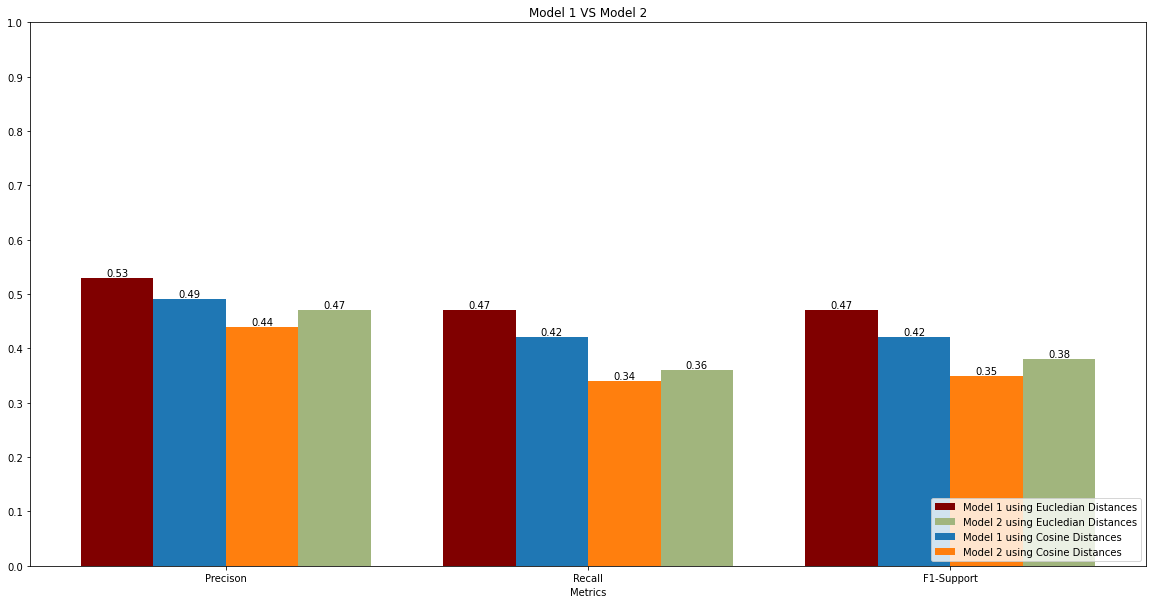

In [ ]:
X = ['Precison', 'Recall', 'F1-Support']

Y_1 = [p1_E, rec1_E, f1_1_E]
Y_2 = [p2_E, rec2_E, f1_2_E]
Y_3 = [p1_C, rec1_C, f1_1_C]
Y_4 = [p2_C, rec2_C, f1_2_C]

X_Axis = np.arange(4, 16, 4)

f = plt.figure()
f.set_figheight(10)
f.set_figwidth(20)

b1 = plt.bar(X_Axis - 1.2, Y_1, 0.8, label = 'Model 1 using Eucledian Distances', color='maroon', zorder=3)
b2 = plt.bar(X_Axis + 1.2, Y_2, 0.8, label = 'Model 2 using Eucledian Distances', color='#A1B57D', zorder=3)
b3 = plt.bar(X_Axis - 0.4, Y_3, 0.8, label = 'Model 1 using Cosine Distances', zorder=3)
b4 = plt.bar(X_Axis + 0.4, Y_4, 0.8, label = 'Model 2 using Cosine Distances', zorder=3)
# plt.bar(X_Axis, Y_f1, 0.2, label = 'F1')
# plt.bar(X_Axis + 0.15, Y_sup, 0.2, label = 'Support')

for rect in b1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

for rect in b2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

for rect in b3:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

for rect in b4:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')


# f = plt.figure()
# plt.grid(True, zorder=0)
plt.xticks(X_Axis, X)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Metrics")
plt.title("Model 1 VS Model 2")
plt.legend(loc=4)

plt.show()